In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import commons as cmns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# from IPython.display import Audio
# sound_file = 'beep.wav'

In [2]:
data=pd.read_csv('../Data/btc_Data.csv',sep=',')

In [3]:
data.interpolate(axis=0,inplace=True)

In [4]:
interval=(data['Date'] >= '2016/01/01') & (data['Date'] <= '2019/12/31')

In [5]:
one=data['priceUSD'].shift(-1,fill_value=1)
seven=data['priceUSD'].shift(-7,fill_value=1)
fourteen=data['priceUSD'].shift(-14,fill_value=1)
thirty=data['priceUSD'].shift(-30,fill_value=1)
sixty=data['priceUSD'].shift(-60,fill_value=1)
ninety=data['priceUSD'].shift(-90,fill_value=1)

In [6]:
df=data.loc[interval]

In [7]:
df['priceUSD']=thirty.loc[interval].copy() # shift 30 days to predict the price after 30 days

/tmp/ipykernel_513826/2886425534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['priceUSD']=thirty.loc[interval].copy() # shift 30 days to predict the price after 30 days


In [8]:
df.shape

(1461, 738)

In [9]:
df.reset_index(inplace=True)
df

,index,Unnamed: 0,Date,priceUSD,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,...,price3rsiUSD,price7rsiUSD,price14rsiUSD,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD
0,1994,1994,2016/01/01,377.724,123957,493324.0,201778,1.038803e+11,7.143095e+17,2.054,...,62.981,50.258,54.957,59.317,58.983,1.685,-4.896,-5.905,21.539,81.331
1,1995,1995,2016/01/02,373.237,148893,579661.0,260130,1.038803e+11,7.045287e+17,2.248,...,65.888,51.437,55.417,59.492,59.051,0.991,1.124,-6.344,19.704,81.429
2,1996,1996,2016/01/03,374.287,142463,554573.0,244440,1.038803e+11,7.770801e+17,2.016,...,44.636,46.265,53.054,58.441,58.653,0.906,2.877,-5.372,19.249,79.819
3,1997,1997,2016/01/04,372.194,181173,556888.0,279282,1.038803e+11,8.502728e+17,2.314,...,57.755,50.028,54.398,58.923,58.833,-0.102,1.817,-1.291,15.217,77.604
4,1998,1998,2016/01/05,378.350,182214,641696.0,291077,1.038803e+11,8.448980e+17,2.025,...,60.104,50.695,54.630,59.004,58.863,-0.231,1.681,-1.550,9.791,76.236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,3450,3450,2019/12/27,8466.000,322059,709273.0,415723,1.294859e+13,9.725392e+19,0.137,...,40.778,49.822,46.261,42.961,46.220,-1.348,0.717,0.076,-0.081,-11.109
1457,3451,3451,2019/12/28,8744.000,298138,625161.0,376120,1.294859e+13,9.517417e+19,0.145,...,66.949,57.573,50.044,44.575,46.608,1.080,2.124,2.180,-2.562,-9.029
1458,3452,3452,2019/12/29,9049.000,279770,552879.0,344377,1.294859e+13,1.010148e+20,0.144,...,80.850,64.565,53.873,46.295,47.031,2.631,2.658,4.788,-1.656,-7.569
1459,3453,3453,2019/12/30,9349.000,324331,661326.0,418908,1.294859e+13,1.018722e+20,0.152,...,54.857,56.418,50.728,45.205,46.750,1.722,-1.875,4.286,-3.716,-11.675


In [10]:
df = df.iloc[:,2:]
df

,Date,priceUSD,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,sentinusdUSD,transactionfeesUSD,...,price3rsiUSD,price7rsiUSD,price14rsiUSD,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD
0,2016/01/01,377.724,123957,493324.0,201778,1.038803e+11,7.143095e+17,2.054,3.790767e+08,0.0691,...,62.981,50.258,54.957,59.317,58.983,1.685,-4.896,-5.905,21.539,81.331
1,2016/01/02,373.237,148893,579661.0,260130,1.038803e+11,7.045287e+17,2.248,3.160521e+08,0.0913,...,65.888,51.437,55.417,59.492,59.051,0.991,1.124,-6.344,19.704,81.429
2,2016/01/03,374.287,142463,554573.0,244440,1.038803e+11,7.770801e+17,2.016,3.350245e+08,0.0726,...,44.636,46.265,53.054,58.441,58.653,0.906,2.877,-5.372,19.249,79.819
3,2016/01/04,372.194,181173,556888.0,279282,1.038803e+11,8.502728e+17,2.314,4.035271e+08,0.0733,...,57.755,50.028,54.398,58.923,58.833,-0.102,1.817,-1.291,15.217,77.604
4,2016/01/05,378.350,182214,641696.0,291077,1.038803e+11,8.448980e+17,2.025,5.397410e+08,0.0766,...,60.104,50.695,54.630,59.004,58.863,-0.231,1.681,-1.550,9.791,76.236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2019/12/27,8466.000,322059,709273.0,415723,1.294859e+13,9.725392e+19,0.137,3.906419e+09,0.3860,...,40.778,49.822,46.261,42.961,46.220,-1.348,0.717,0.076,-0.081,-11.109
1457,2019/12/28,8744.000,298138,625161.0,376120,1.294859e+13,9.517417e+19,0.145,3.214321e+09,0.3410,...,66.949,57.573,50.044,44.575,46.608,1.080,2.124,2.180,-2.562,-9.029
1458,2019/12/29,9049.000,279770,552879.0,344377,1.294859e+13,1.010148e+20,0.144,2.491859e+09,0.3370,...,80.850,64.565,53.873,46.295,47.031,2.631,2.658,4.788,-1.656,-7.569
1459,2019/12/30,9349.000,324331,661326.0,418908,1.294859e+13,1.018722e+20,0.152,4.650041e+09,0.3620,...,54.857,56.418,50.728,45.205,46.750,1.722,-1.875,4.286,-3.716,-11.675


In [11]:
X_raw=df.iloc[:,2:17]

In [12]:
y=df.iloc[:,1:2]
y=np.ravel(y)

In [13]:
date = df['Date']

In [14]:
features_list=[]
technical_indicators=['sma','ema','wma','trx','mom','std','var','rsi','roc']
periods=['3','7','14','30','90']
for i in technical_indicators:
    for j in periods:
        string=str(j)+str(i)
        X=df.filter(like=string,axis=1)
        X=SimpleImputer(missing_values=0,strategy='most_frequent').fit_transform(X)
        X=pd.DataFrame(X)
        X.columns=df.filter(like=string,axis=1).columns
        rf1=RandomForestRegressor(random_state=7,n_jobs=-1)
        rfecv=RFECV(rf1,step=0.9,min_features_to_select=20,verbose=1,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1)
        rfecv.fit(X,y)
        if rfecv.n_features_>1:
            rf1.fit(X,y)
            maximp=rf1.feature_importances_.max()
            for x in range(len(rf1.feature_importances_)):
                if maximp==rf1.feature_importances_[x]:
                    new_features = X.columns[x]
        else:
            mask = rfecv.get_support()
            new_features = X.columns[mask]
        features_list.append(str(new_features))
        print(string+': '+new_features)
# Audio(sound_file, autoplay=True)

3sma: price3smaUSD
7sma: price7smaUSD
14sma: price14smaUSD
30sma: price30smaUSD
90sma: difficulty90sma
3ema: price3emaUSD
7ema: price7emaUSD
14ema: price14emaUSD
30ema: price30emaUSD
90ema: sentinusd90emaUSD
3wma: price3wmaUSD
7wma: price7wmaUSD
14wma: price14wmaUSD
30wma: price30wmaUSD
90wma: price90wmaUSD
3trx: median_transaction_fee3trxUSD
7trx: median_transaction_fee7trxUSD
14trx: top100cap14trx
30trx: top100cap30trx
90trx: top100cap90trx
3mom: hashrate3mom
7mom: hashrate7mom
14mom: difficulty14mom
30mom: difficulty30mom
90mom: difficulty90mom
3std: hashrate3std
7std: hashrate7std
14std: hashrate14std
30std: hashrate30std
90std: hashrate90std
3var: hashrate3var
7var: hashrate7var
14var: hashrate14var
30var: hashrate30var
90var: hashrate90var
3rsi: difficulty3rsi
7rsi: top100cap7rsi
14rsi: top100cap14rsi
30rsi: top100cap30rsi
90rsi: top100cap90rsi
3roc: median_transaction_fee3rocUSD
7roc: median_transaction_fee7rocUSD
14roc: median_transaction_fee14rocUSD
30roc: median_transaction_f

In [15]:
l1=[]
for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

In [16]:
l1.sort()

In [17]:
l1

['difficulty14mom',
 'difficulty30mom',
 'difficulty3rsi',
 'difficulty90mom',
 'difficulty90sma',
 'hashrate14std',
 'hashrate14var',
 'hashrate30std',
 'hashrate30var',
 'hashrate3mom',
 'hashrate3std',
 'hashrate3var',
 'hashrate7mom',
 'hashrate7std',
 'hashrate7var',
 'hashrate90std',
 'hashrate90var',
 'median_transaction_fee14rocUSD',
 'median_transaction_fee30rocUSD',
 'median_transaction_fee3rocUSD',
 'median_transaction_fee3trxUSD',
 'median_transaction_fee7rocUSD',
 'median_transaction_fee7trxUSD',
 'median_transaction_fee90rocUSD',
 'price14emaUSD',
 'price14smaUSD',
 'price14wmaUSD',
 'price30emaUSD',
 'price30smaUSD',
 'price30wmaUSD',
 'price3emaUSD',
 'price3smaUSD',
 'price3wmaUSD',
 'price7emaUSD',
 'price7smaUSD',
 'price7wmaUSD',
 'price90wmaUSD',
 'sentinusd90emaUSD',
 'top100cap14rsi',
 'top100cap14trx',
 'top100cap30rsi',
 'top100cap30trx',
 'top100cap7rsi',
 'top100cap90rsi',
 'top100cap90trx']

In [18]:
df_reduced=df[l1]

In [19]:
df_reduced.head()

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate14std,hashrate14var,hashrate30std,hashrate30var,hashrate3mom,...,price7wmaUSD,price90wmaUSD,sentinusd90emaUSD,top100cap14rsi,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap7rsi,top100cap90rsi,top100cap90trx
0,2.282551e+10,3.115756e+10,100.0,4.306712e+10,7.116974e+10,1.219735e+17,3.719386e+33,1.617952e+17,6.544426e+33,-5.947531e+15,...,427.105,385.719,968689520,39.717,-0.080,42.483,-0.034,44.469,47.720,-0.013
1,1.043167e+10,3.115756e+10,100.0,4.306712e+10,7.164827e+10,1.239125e+17,3.838574e+33,1.527793e+17,5.835382e+33,-6.220449e+16,...,428.930,387.556,954345841,39.375,-0.080,42.355,-0.035,43.380,47.697,-0.013
2,1.043167e+10,3.115756e+10,100.0,4.306712e+10,7.212679e+10,1.246174e+17,3.882372e+33,1.425257e+17,5.078392e+33,3.393821e+16,...,429.592,389.258,940734382,38.495,-0.079,42.032,-0.036,40.524,47.640,-0.013
3,1.043167e+10,3.115756e+10,100.0,4.306712e+10,7.260531e+10,1.354776e+17,4.588543e+33,1.432059e+17,5.126986e+33,1.359634e+17,...,430.461,390.970,928927628,42.792,-0.077,43.426,-0.037,52.027,47.837,-0.014
4,1.043167e+10,3.099707e+10,100.0,4.306712e+10,7.308384e+10,1.328632e+17,4.413161e+33,1.455622e+17,5.297087e+33,1.403693e+17,...,431.161,392.645,920374075,43.564,-0.074,43.681,-0.038,53.919,47.873,-0.014


In [20]:
X=cmns.drop_high_vif(df_reduced,thresh=5)

dropping 'hashrate14var' at index: 6
dropping 'hashrate7std' at index: 12
dropping 'hashrate30var' at index: 7
dropping 'hashrate3std' at index: 8
Remaining variables:
Index(['difficulty14mom', 'difficulty30mom', 'difficulty3rsi',
       'difficulty90mom', 'difficulty90sma', 'hashrate14std', 'hashrate30std',
       'hashrate3mom', 'hashrate3var', 'hashrate7mom', 'hashrate7var',
       'hashrate90std', 'hashrate90var', 'median_transaction_fee14rocUSD',
       'median_transaction_fee30rocUSD', 'median_transaction_fee3rocUSD',
       'median_transaction_fee3trxUSD', 'median_transaction_fee7rocUSD',
       'median_transaction_fee7trxUSD', 'median_transaction_fee90rocUSD',
       'price14emaUSD', 'price14smaUSD', 'price14wmaUSD', 'price30emaUSD',
       'price30smaUSD', 'price30wmaUSD', 'price3emaUSD', 'price3smaUSD',
       'price3wmaUSD', 'price7emaUSD', 'price7smaUSD', 'price7wmaUSD',
       'price90wmaUSD', 'sentinusd90emaUSD', 'top100cap14rsi',
       'top100cap14trx', 'top100cap30rsi'

In [21]:
X.shape

(1461, 41)

In [22]:
cmns.vif_values(X)

difficulty14mom                   1.161246
difficulty30mom                   1.347881
difficulty3rsi                    0.232528
difficulty90mom                   2.004575
difficulty90sma                   2.923773
hashrate14std                     3.490811
hashrate30std                     3.084591
hashrate3mom                      1.010894
hashrate3var                      2.478937
hashrate7mom                      1.011822
hashrate7var                      3.239340
hashrate90std                     4.613597
hashrate90var                     1.714191
median_transaction_fee14rocUSD    0.956695
median_transaction_fee30rocUSD    0.911437
median_transaction_fee3rocUSD     0.994085
median_transaction_fee3trxUSD     0.999832
median_transaction_fee7rocUSD     0.983261
median_transaction_fee7trxUSD     1.013585
median_transaction_fee90rocUSD    0.887244
price14emaUSD                     0.763681
price14smaUSD                     0.765116
price14wmaUSD                     0.756856
price30emaU

In [23]:
Raw=cmns.drop_high_vif(X_raw,thresh=10)

dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
Remaining variables:
Index(['transactions', 'size', 'sentbyaddress', 'difficulty',
       'mining_profitability', 'sentinusdUSD', 'median_transaction_feeUSD',
       'confirmationtime', 'transactionvalueUSD', 'mediantransactionvalueUSD',
       'activeaddresses', 'top100cap', 'fee_to_rewardUSD'],
      dtype='object')


In [24]:
#cmns.vif_values(X_raw)
cmns.vif_values(Raw)

transactions                 7.311387
size                         3.806699
sentbyaddress                8.644937
difficulty                   9.748140
mining_profitability         4.134450
sentinusdUSD                 3.910395
median_transaction_feeUSD    9.367094
confirmationtime             1.532086
transactionvalueUSD          1.791431
mediantransactionvalueUSD    5.677707
activeaddresses              3.731714
top100cap                    0.956696
fee_to_rewardUSD             5.859367
dtype: float64

In [25]:
Raw['Date']=df['Date']

/tmp/ipykernel_513826/3240872751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Raw['Date']=df['Date']


In [26]:
X['Date']=df['Date']

/tmp/ipykernel_513826/227219659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date']=df['Date']


In [27]:
df_merged=Raw.merge(X.drop_duplicates(subset='Date'),how='left')

In [28]:
df_merged.shape

(1461, 55)

In [29]:
df_merged.drop(columns='Date',inplace=True)

In [30]:
#df_merged['priceUSD']=np.ravel(y)

In [31]:
X=cmns.drop_high_vif(df_merged,thresh=10)

Remaining variables:
Index(['transactions', 'size', 'sentbyaddress', 'difficulty',
       'mining_profitability', 'sentinusdUSD', 'median_transaction_feeUSD',
       'confirmationtime', 'transactionvalueUSD', 'mediantransactionvalueUSD',
       'activeaddresses', 'top100cap', 'fee_to_rewardUSD', 'difficulty14mom',
       'difficulty30mom', 'difficulty3rsi', 'difficulty90mom',
       'difficulty90sma', 'hashrate14std', 'hashrate30std', 'hashrate3mom',
       'hashrate3var', 'hashrate7mom', 'hashrate7var', 'hashrate90std',
       'hashrate90var', 'median_transaction_fee14rocUSD',
       'median_transaction_fee30rocUSD', 'median_transaction_fee3rocUSD',
       'median_transaction_fee3trxUSD', 'median_transaction_fee7rocUSD',
       'median_transaction_fee7trxUSD', 'median_transaction_fee90rocUSD',
       'price14emaUSD', 'price14smaUSD', 'price14wmaUSD', 'price30emaUSD',
       'price30smaUSD', 'price30wmaUSD', 'price3emaUSD', 'price3smaUSD',
       'price3wmaUSD', 'price7emaUSD', 'price7

In [32]:
X.shape

(1461, 54)

In [33]:
cmns.vif_values(X)

transactions                      0.074956
size                              0.036394
sentbyaddress                     0.055998
difficulty                        3.352513
mining_profitability              0.407760
sentinusdUSD                      0.657990
median_transaction_feeUSD         0.886027
confirmationtime                  0.018862
transactionvalueUSD               0.735119
mediantransactionvalueUSD         0.723291
activeaddresses                   0.086993
top100cap                         0.013246
fee_to_rewardUSD                  0.587134
difficulty14mom                   1.161246
difficulty30mom                   1.347881
difficulty3rsi                    0.232528
difficulty90mom                   2.004575
difficulty90sma                   2.923773
hashrate14std                     3.490811
hashrate30std                     3.084591
hashrate3mom                      1.010894
hashrate3var                      2.478937
hashrate7mom                      1.011822
hashrate7va

In [34]:
if 'priceUSD' in X.columns:
    X.drop(columns='priceUSD',inplace=True)

In [35]:
rf_final=RandomForestRegressor(random_state=7,n_jobs=-1)

In [36]:
rf_final.fit(X,y)

RandomForestRegressor(n_jobs=-1, random_state=7)

In [37]:
imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)

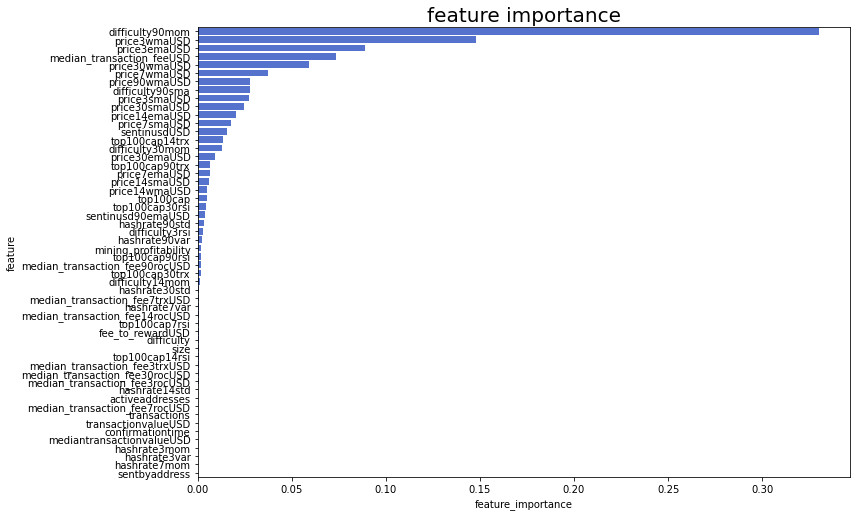

In [38]:
cmns.plot_feature_importance(imp_feat,'feature importance')

In [39]:
imp_feat[imp_feat['feature_importance']>0]


,feature,feature_importance
0,difficulty90mom,0.330373
1,price3wmaUSD,0.147875
2,price3emaUSD,0.088773
3,median_transaction_feeUSD,0.073810
4,price30wmaUSD,0.059305
5,price7wmaUSD,0.037579
6,price90wmaUSD,0.027896
7,difficulty90sma,0.027849
8,price3smaUSD,0.027381
9,price30smaUSD,0.024637


In [40]:
selected=imp_feat[imp_feat['feature_importance']>0.001]

In [41]:
selected

,feature,feature_importance
0,difficulty90mom,0.330373
1,price3wmaUSD,0.147875
2,price3emaUSD,0.088773
3,median_transaction_feeUSD,0.073810
4,price30wmaUSD,0.059305
5,price7wmaUSD,0.037579
6,price90wmaUSD,0.027896
7,difficulty90sma,0.027849
8,price3smaUSD,0.027381
9,price30smaUSD,0.024637


In [42]:
selected.feature_importance.sum()

0.9894100175729116

In [43]:
X_high=X[selected.feature]

In [44]:
X_high.shape

(1461, 31)

In [45]:
X_high.sort_index(axis=1,inplace=True)

/tmp/ipykernel_513826/1654798977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high.sort_index(axis=1,inplace=True)


In [46]:
X_high['priceUSD']=np.ravel(y)

/tmp/ipykernel_513826/671942838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high['priceUSD']=np.ravel(y)


/tmp/ipykernel_513826/957662999.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot:>

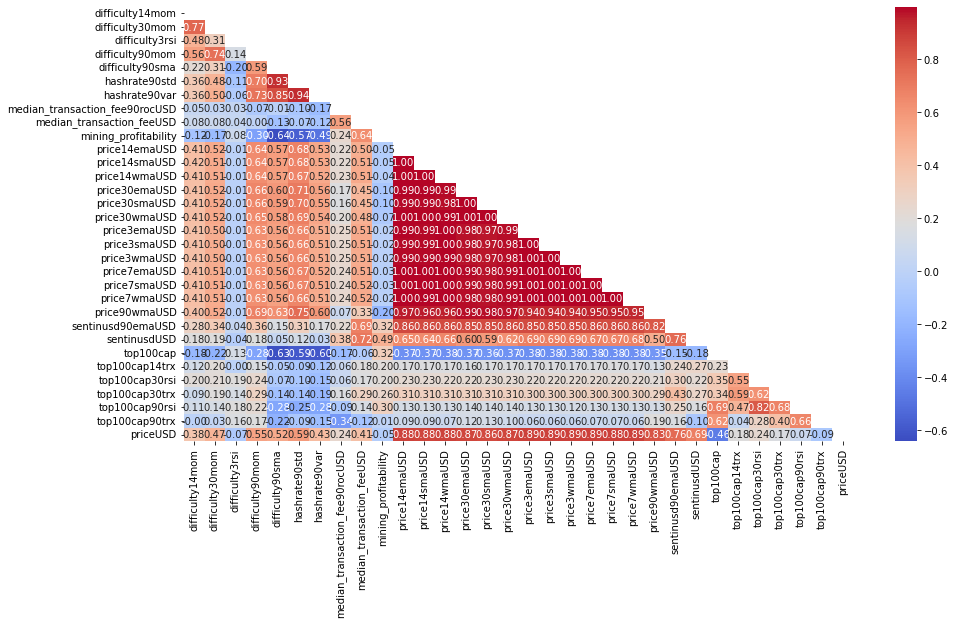

In [47]:
corr = X_high.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [48]:
X_high=X_high[X_high['priceUSD']!=1]

In [49]:
from sklearn.ensemble import IsolationForest
outlier=IsolationForest(contamination=0.3)
price=X_high['priceUSD']
price=price.values
price=np.reshape(price,(-1,1))
outlier.fit(price)
outs=outlier.predict(price)
X_high['outlier']=pd.DataFrame(zip(outs))
X_high=X_high.query('outlier != -1')
X_high.reset_index(drop=True,inplace=True)
X_high.drop(columns=['outlier'],inplace=True)

In [50]:
X_high.to_csv('ltc_reg.csv',sep=',',index=False)

In [51]:
X_high.columns

Index(['difficulty14mom', 'difficulty30mom', 'difficulty3rsi',
       'difficulty90mom', 'difficulty90sma', 'hashrate90std', 'hashrate90var',
       'median_transaction_fee90rocUSD', 'median_transaction_feeUSD',
       'mining_profitability', 'price14emaUSD', 'price14smaUSD',
       'price14wmaUSD', 'price30emaUSD', 'price30smaUSD', 'price30wmaUSD',
       'price3emaUSD', 'price3smaUSD', 'price3wmaUSD', 'price7emaUSD',
       'price7smaUSD', 'price7wmaUSD', 'price90wmaUSD', 'sentinusd90emaUSD',
       'sentinusdUSD', 'top100cap', 'top100cap14trx', 'top100cap30rsi',
       'top100cap30trx', 'top100cap90rsi', 'top100cap90trx', 'priceUSD'],
      dtype='object')